<a href="https://colab.research.google.com/github/yousef11tarek/01001101jn/blob/main/Copy_of_quiz2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covid19-radiography-database:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F576013%2F3324348%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T053637Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D711fed2eb88e991ef08b1d9a7f88cc8702fbb67ee03f92511ffc4dfb87892b539fe1a7770ec4d0e61435cf23ef1e64594b845b463673f7c8b4b3343f2831424bf1bb7805ad25c008a33644ed5c8da20f4ec94fc8cd4971d296ba1b1addecb9c74d285ab932a02059b0aa176e83b9713d33a42e058628a6256a9952cfa8f1073ef61277c937411714ca5674c73602744fdae1d3dba94048cca099c18b1473973f5a08299bc526a74c6cd89c0e8a6640bea312a19e280c631034cc16d170f4bb156ae8a9a49ff7f40e55376a4a24ca78a096fb6bd366a131166df325d663bf5d25114e79b4a8fb44a4b43ddf42b7d478abc908d1bdda693431b9cdd987f25dd32f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 816029038 bytes downloaded
Downloaded and uncompressed: covid19-radiography-database
Data source import complete.


## Library Import

In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import tensorflow as tf


import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

## Data preprocessing

In [3]:
# label tagging to the images

levels = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level + '/images')):
        data.append(['{}/images/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'result'])

data['path'] = path + '/' + data['image_file']

data.head()

,image_file,result,path
0,Normal/images/Normal-7219.png,Normal,../input/covid19-radiography-database/COVID-19...
1,Normal/images/Normal-2070.png,Normal,../input/covid19-radiography-database/COVID-19...
2,Normal/images/Normal-6516.png,Normal,../input/covid19-radiography-database/COVID-19...
3,Normal/images/Normal-2291.png,Normal,../input/covid19-radiography-database/COVID-19...
4,Normal/images/Normal-7510.png,Normal,../input/covid19-radiography-database/COVID-19...


<ipython-input-4-6e24529e5eb0>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  sx.set_xticklabels(labels=sx.get_xticklabels(), rotation=90)


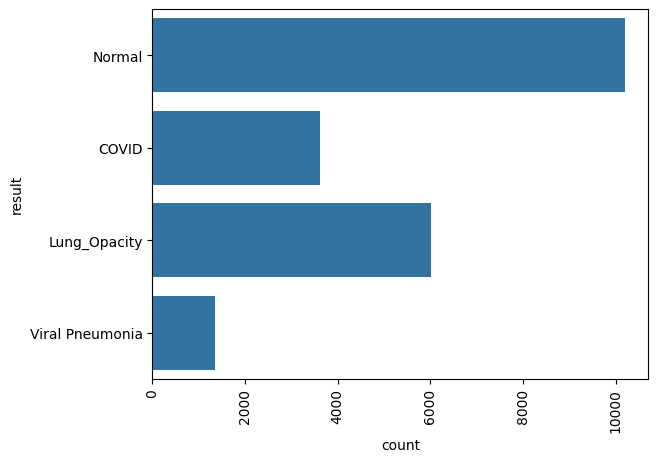

In [4]:
sx = sns.countplot(data['result'])
sx.set_xticklabels(labels=sx.get_xticklabels(), rotation=90)
plt.show()

In [5]:
pixel_img = []

for image in tqdm(data['path']):
    img=Image.open(image)
    img=ImageOps.grayscale(img)
    img=img.resize((64,64))
    img=np.asarray(img)
    img=img.reshape((64,64,1))
    pixel_img.append(img)

100%|██████████| 21165/21165 [00:46<00:00, 452.14it/s]


In [6]:
pixel_img = np.array(pixel_img)
label_img = data['result'].map({'Normal': 0, 'COVID': 1, 'Lung_Opacity' : 2,
                               'Viral Pneumonia' : 3})

print(pixel_img.shape, label_img.shape)

(21165, 64, 64, 1) (21165,)


In [7]:
#20% will be used for test
X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img,test_size=0.2, stratify=label_img)
#16932 images for train et 4233 for test

In [8]:
input_size = X_train.shape[1] * X_train.shape[2]
print(input_size)

num_classes = len(np.unique(y_train))
print(num_classes)

4096
4


In [9]:
# flatten the image
X_train = np.reshape(X_train, [X_train.shape[0], input_size])
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, [X_test.shape[0], input_size])
X_test = X_test.astype('float32') / 255

## Machine learning models

In [10]:
from sklearn.naive_bayes import MultinomialNB

# Train the MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train,y_train)

# Evaluate the model
y_pred = nb_model.predict(X_test)

In [11]:
accuracy_score(y_test, y_pred)

0.5542168674698795

In [12]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

print(f"Classification report for classifier {nb_model}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Classification report for classifier MultinomialNB():
              precision    recall  f1-score   support

           0       0.78      0.52      0.62      2038
           1       0.32      0.51      0.39       723
           2       0.63      0.57      0.60      1203
           3       0.36      0.84      0.50       269

    accuracy                           0.55      4233
   macro avg       0.52      0.61      0.53      4233
weighted avg       0.63      0.55      0.57      4233




In [13]:
from sklearn import svm
svm_model=svm.SVC(kernel='rbf')
svm_model.fit(X_train , y_train)
y_pred=svm_model.predict(X_test)

# Train the SVM


# Evaluate the model
y_pred = svm_model.predict(X_test)

In [14]:
accuracy_score(y_test, y_pred)

0.8348688873139617

In [15]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

print(f"Classification report for classifier {svm_model}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Classification report for classifier SVC():
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2038
           1       0.82      0.66      0.73       723
           2       0.82      0.77      0.80      1203
           3       0.94      0.88      0.91       269

    accuracy                           0.83      4233
   macro avg       0.85      0.81      0.83      4233
weighted avg       0.83      0.83      0.83      4233




## ConvNet

In [16]:
# Reconstruct 2D matrix 64x64
# 20% for test

X_train, X_test, y_train, y_test = train_test_split(pixel_img, label_img,
                                                    test_size=0.2, stratify=label_img)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

input_shape = (X_train.shape[1],X_train.shape[2],1)

(16932, 64, 64, 1)
(4233, 64, 64, 1)
(16932, 4)
(4233, 4)


In [19]:
cnn_model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
cnn_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 31, 31, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 32)        9248      
                                                      

In [20]:
cnn_model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

start_time = time.time()
history = cnn_model1.fit(X_train, y_train, epochs=50, batch_size=128)
print("Temps de calcul :", time.time() - start_time)

Epoch 1/50
133/133 [==============================] - 21s 42ms/step - loss: 0.9341 - accuracy: 0.6117
Epoch 2/50
133/133 [==============================] - 5s 36ms/step - loss: 0.6936 - accuracy: 0.7227
Epoch 3/50
133/133 [==============================] - 5s 40ms/step - loss: 0.6081 - accuracy: 0.7581
Epoch 4/50
133/133 [==============================] - 6s 44ms/step - loss: 0.5332 - accuracy: 0.7932
Epoch 5/50
133/133 [==============================] - 6s 42ms/step - loss: 0.4728 - accuracy: 0.8180
Epoch 6/50
133/133 [==============================] - 6s 41ms/step - loss: 0.4278 - accuracy: 0.8352
Epoch 7/50
133/133 [==============================] - 5s 37ms/step - loss: 0.4077 - accuracy: 0.8439
Epoch 8/50
133/133 [==============================] - 4s 34ms/step - loss: 0.3867 - accuracy: 0.8514
Epoch 9/50
133/133 [==============================] - 5s 35ms/step - loss: 0.3631 - accuracy: 0.8621
Epoch 10/50
133/133 [==============================] - 4s 33ms/step - loss: 0.3423 - accur

In [22]:
loss, acc = cnn_model1.evaluate(X_test, y_test, verbose=0)

print("Accuracy model8 adam: %.2f%%" % (100.0 * acc))

predictions = cnn_model1.predict(X_test)
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

Accuracy model8 adam: 91.92%
133/133 [==============================] - 0s 3ms/step


col_0,0,1,2,3
row_0,,,,
0,1923,24,84,7
1,15,676,31,1
2,135,20,1047,1
3,17,4,3,245


In [23]:
# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

print("Classification report for classifier :\n"
      f"{metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))}\n")

Classification report for classifier :
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2038
           1       0.93      0.93      0.93       723
           2       0.90      0.87      0.88      1203
           3       0.96      0.91      0.94       269

    accuracy                           0.92      4233
   macro avg       0.93      0.91      0.92      4233
weighted avg       0.92      0.92      0.92      4233


